In [1]:
import xarray as xr
import metpy.calc as mpcalc
from metpy.units import units
import numpy as np

In [2]:
xr.set_options(keep_attrs=True)

In [3]:
# Xarray Dataset Methods

def load_dataset(file_path: str) -> xr.Dataset:
    with xr.open_dataset(file_path, engine="netcdf4") as ds:
        return ds

In [4]:
def slice_dataset_by_coord(
    dataset: xr.Dataset, 
    lat: list[int],
    lon: list[int]
) -> xr.Dataset:
    """
    Slices a dataset using latitudes and longitudes, returns a dataset 
    with the mean values between the coordinates.
    """
    ds = dataset.sel(latitude=lat, longitude=lon, method='nearest')
    return ds.mean(dim=["latitude", "longitude"])

In [5]:
def convert_to_br_units(dataset: xr.Dataset) -> xr.Dataset:
    """
    Parse the units according to Brazil's standard unit measures.
    Rename their unit names and long names as well. 
    """
    ds = dataset
    vars = list(ds.data_vars.keys())

    if 't2m' in vars:
        #Convert Kelvin to Celsius degrees
        ds['t2m'] = ds.t2m - 273.15
        ds['t2m'].attrs = {
            'units': 'degC', 
            'long_name': 'Temperatura'} 
    if 'tp' in vars:
        #Convert meters to millimeters
        ds['tp'] = ds.tp * 1000
        ds['tp'].attrs = {
            'units': 'mm',
            'long_name': 'Precipitação'}
    if 'msl' in vars:
        #Convert Pa to ATM
        ds['msl'] = ds.msl * 0.00000986923
        ds['msl'].attrs = {
            'units': 'atm',
            'long_name': 'Pressão ao Nível do Mar'}
    if 'd2m' in vars:
        #Calculate Relative Humidity percentage and add to Dataset 
        ds['d2m'] = ds.d2m - 273.15
        rh = mpcalc.relative_humidity_from_dewpoint(
                ds['t2m'] * units.degC, ds['d2m'] * units.degC) * 100
        #Replacing the variable instead of dropping. d2m won't be used.
        ds['d2m'] = rh
        ds['d2m'].attrs = {
            'units': 'pct',
            'long_name': 'Umidade Relativa do Ar'}
    
    with_br_names = {
        't2m': 'temp', 
        'tp': 'precip', 
        'msl': 'pressao',
        'd2m': 'umid'
    }
    
    return ds.rename(with_br_names)

In [6]:
def reduce_by(ds, f, prefix):
    ds = ds.apply(func=f)
    return ds.rename(dict(zip(list(ds.data_vars), list(map(lambda x: f'{x}_{prefix}', list(ds.data_vars))))))

---

In [7]:
# file = 'data/BR_20221130.nc'
file = '/home/luabida/Projetos/OSL/satellite-weather-downloader/data/BR_20220101_20220301.nc'

In [8]:
ds = load_dataset(file)

In [9]:
ds.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:    (longitude: 168, latitude: 158, time: 720)
Coordinates:
  * longitude  (longitude) float32 -74.0 -73.75 -73.5 ... -32.75 -32.5 -32.25
  * latitude   (latitude) float32 5.5 5.25 5.0 4.75 ... -33.25 -33.5 -33.75
  * time       (time) datetime64[ns] 2022-01-01 ... 2022-03-31T21:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tp         (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-01-10 16:08:26 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...>

In [10]:
lat = [-25.5]
lon = [-54.5, -54.75]
foz = slice_dataset_by_coord(ds, lat=lat, lon=lon)
foz

<xarray.Dataset>
Dimensions:  (time: 720)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 ... 2022-03-31T21:00:00
Data variables:
    t2m      (time) float32 301.7 299.4 296.9 296.0 ... 287.3 291.6 293.7 292.9
    tp       (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    d2m      (time) float32 292.7 292.2 292.5 293.1 ... 281.7 283.7 283.3 282.1
    msl      (time) float32 1.004e+05 1.005e+05 ... 1.018e+05 1.018e+05
Attributes:
    Conventions:  CF-1.6
    history:      2023-01-10 16:08:26 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [11]:
br_foz = convert_to_br_units(foz)
br_foz

<xarray.Dataset>
Dimensions:  (time: 720)
Coordinates:
  * time     (time) datetime64[ns] 2022-01-01 ... 2022-03-31T21:00:00
Data variables:
    temp     (time) float32 28.57 26.26 23.73 22.87 ... 14.12 18.42 20.55 19.74
    precip   (time) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0
    umid     (time) float32 <Quantity([58.05257  64.65325  76.35956  83.65098...
    pressao  (time) float32 0.9908 0.992 0.9913 0.9929 ... 1.006 1.004 1.004
Attributes:
    Conventions:  CF-1.6
    history:      2023-01-10 16:08:26 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [12]:
gb = br_foz.groupby('time.dayofyear')

In [13]:
foz_min = reduce_by(gb, np.min, 'min')

In [14]:
foz_med = reduce_by(gb, np.mean, 'med')

In [15]:
foz_max = reduce_by(gb, np.max, 'max')
foz_max

Magnitude,[83.65098571777344 71.58865356445312 81.39485931396484 90.61811828613281 95.21065521240234 87.33966064453125 82.32428741455078 90.89473724365234 87.72531127929688 89.16000366210938 88.99539947509766 85.47908782958984 86.51849365234375 83.76469421386719 86.64495086669922 77.42240905761719 76.92790985107422 72.01470947265625 71.56613159179688 83.73402404785156 76.37136840820312 72.57454681396484 72.41299438476562 75.99113464355469 82.65977478027344 92.5261001586914 93.3071517944336 93.72638702392578 85.3642349243164 88.48282623291016 91.21461486816406 87.64012908935547 81.80567932128906 80.16458129882812 97.19029998779297 97.84400939941406 99.5140151977539 80.01020812988281 79.66525268554688 84.55217742919922 83.69730377197266 83.21968078613281 79.8790283203125 88.03800964355469 87.64750671386719 68.79753112792969 68.71415710449219 76.79232025146484 70.4007339477539 76.83560943603516 70.70362091064453 88.32763671875 90.41082000732422 93.5512466430664 82.24797058105469 86.00640869140625 89.56243133544922 80.41845703125 76.04753875732422 95.81023406982422 94.55638885498047 94.93692779541016 93.05992126464844 88.71736145019531 86.63694763183594 79.06018829345703 86.39644622802734 91.2496337890625 88.08259582519531 97.28671264648438 96.35706329345703 94.93511962890625 95.81306457519531 89.86244201660156 93.70000457763672 92.28312683105469 81.26036834716797 99.411865234375 96.64567565917969 88.44879150390625 76.93016052246094 83.81726837158203 96.87049102783203 99.99850463867188 94.33712005615234 93.59119415283203 90.2291259765625 88.61359405517578 93.58308410644531 85.39643859863281]
Units,dimensionless


In [21]:
res = xr.combine_by_coords([foz_min, foz_med, foz_max], data_vars='all')
res.to_dataframe()

,temp_max,precip_max,umid_max,pressao_max,temp_med,precip_med,umid_med,pressao_med,temp_min,precip_min,umid_min,pressao_min
dayofyear,,,,,,,,,,,,
1,36.768036,0.000000,83.650986,0.994654,29.536167,0.000000,55.286049,0.991700,22.870667,0.0,27.084122,0.988875
2,36.940308,0.010720,71.588654,0.995000,30.757278,0.001340,50.800785,0.992436,24.778870,0.0,33.520031,0.990157
3,29.768311,0.060752,81.394859,0.997061,26.478722,0.025089,68.912376,0.994725,24.234253,0.0,58.161205,0.992824
4,31.206177,1.645069,90.618118,0.993219,26.292370,0.405757,77.177979,0.991471,22.825531,0.0,60.958790,0.988654
5,34.101959,0.268916,95.210655,0.993462,27.752060,0.054125,71.664452,0.991416,22.548004,0.0,39.690147,0.989787
...,...,...,...,...,...,...,...,...,...,...,...,...
86,27.503265,0.000000,93.591194,1.003086,21.313290,0.000000,76.667946,1.000828,16.457489,0.0,52.598244,0.998777
87,30.861176,0.000000,90.229126,1.003574,23.444962,0.000000,71.412704,1.001559,17.476074,0.0,47.216148,0.998791
88,32.229767,0.076832,88.613594,1.000662,26.567703,0.011056,72.415764,0.998145,22.262238,0.0,54.137348,0.994526


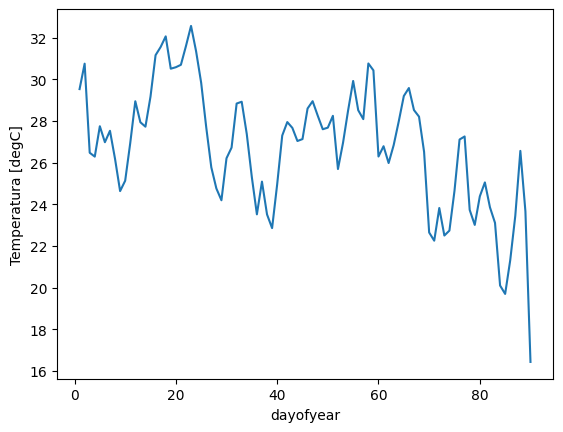

In [17]:
res.temp_med.plot()

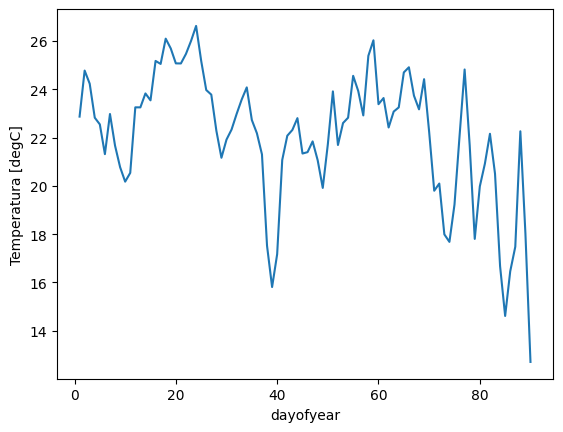

In [19]:
res.temp_min.plot()

----